In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations

In [3]:
def generate_subsets(n):
    # Generate all possible subsets of size 1 to n.
    for size in range(1, n + 1):
        for subset in combinations(range(n), size):
            yield subset
            # print(subset)


def check_p(matrix):
    n = len(matrix)

    # Compute the determinant of the whole matrix first.
    determinant = np.linalg.det(matrix)
    if determinant <= 0:
        return False  # Return immediately if the whole matrix has a non-positive determinant

    # Check the determinants of diagonal elements (smallest subset) next.
    for i in range(n):
        submatrix = matrix[i, i]
        if submatrix <= 0:
            return False  # Return immediately if any diagonal element is non-positive

    # Initialize the generator to get subsets.
    subset_generator = generate_subsets(n)

    # Check the determinants of other subsets.
    for subset in subset_generator:
        if len(subset) > 1:
            submatrix = matrix[np.ix_(subset, subset)]
            determinant = np.linalg.det(submatrix)
            if determinant <= 0:
                return False  # Return immediately if a non-positive determinant is found

    return True # Return True if all determinants are positive


def generate_matrix(n):
    # Generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

In [4]:
# n = 3
# iterations = 100
# kappa = 0.5
# all_p = 0
# G1_p_G2_p_G_n = 0
# G1_n_G2_p_G_p = 0
# G1_n_G2_p_G_n = 0
# G1_n_G2_n_G_p = 0
# non_p = 0

# for i in range(iterations):
#     G1 = generate_matrix(n)
#     G2 = generate_matrix(n)
#     G = kappa * G1 + (1 - kappa) * G2
#     result1 = check_p(G1)
#     result2 = check_p(G2)
#     result = check_p(G)
    
#     if result1 & result2 & result:
#         all_p += 1
#     elif result1 & result2 & (not result):
#         G1_p_G2_p_G_n += 1
#     elif (result1 & (not result2) & result) or ((not result1) and result2 and result):
#         G1_n_G2_p_G_p += 1
#     elif (result1 & (not result2) & (not result)) or ((not result1) and result2 and (not result)):
#         G1_n_G2_p_G_n += 1
#     elif (not result1) and (not result2) and result:
#         G1_n_G2_n_G_p += 1
#     elif (not result1) and (not result2) and (not result):
#         non_p += 1

    
# print("layers have a unique NE and so does the Multiplex: ", all_p)
# print("layers have a unique NE but the Multiplex does not: ", G1_p_G2_p_G_n)
# print("only one layer has a unique NE and so does the Multiplex: ", G1_n_G2_p_G_p)
# print("only one layer has a unique NE but the Multiplex does not: ", G1_n_G2_p_G_n)
# print("no layer has a unique NE but the Multiplex does: ", G1_n_G2_n_G_p)
# print("no layer has a unique NE and neither does the Multiplex: ", non_p)
# print("total: ", all_p + G1_p_G2_p_G_n + G1_n_G2_p_G_p + G1_n_G2_p_G_n + G1_n_G2_n_G_p + non_p)

# # categories = ['Layers and Multiplex \u2192 NE', 'Both layers \u2192 NE\nMultiplex \u219B NE', 'One layer \u2192 NE\nMultiplex \u2192 NE', 'One layer \u2192 NE\nmultiplex \u219B NE', 'Neither the layers nor\nthe Multiplex with NE']


In [5]:
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]

# # Setting up subplots with shared y-axis
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, gridspec_kw={'hspace': 0.4, 'wspace': 0.2})

# for i, n in enumerate(n_list):
#     all_p = 0
#     G1_p_G2_p_G_n = 0
#     G1_n_G2_p_G_p = 0
#     G1_n_G2_p_G_n = 0
#     G1_n_G2_n_G_p = 0
#     non_p = 0

#     iterations = 100
#     kappa = 0.5

#     for j in range(iterations):
#         G1 = generate_matrix(n)
#         G2 = generate_matrix(n)
#         G = kappa * G1 + (1 - kappa) * G2
#         result1 = check_p(G1)
#         result2 = check_p(G2)
#         result = check_p(G)

#         if result1 & result2 & result:
#             all_p += 1
#         elif result1 & result2 & (not result):
#             G1_p_G2_p_G_n += 1
#         elif (result1 & (not result2) & result) or ((not result1) and result2 and result):
#             G1_n_G2_p_G_p += 1
#         elif (result1 & (not result2) & (not result)) or ((not result1) and result2 and (not result)):
#             G1_n_G2_p_G_n += 1
#         elif (not result1) and (not result2) and result:
#             G1_n_G2_n_G_p += 1
#         elif (not result1) and (not result2) and (not result):
#             non_p += 1

#     # Creating a bar plot for each n in a subplot
#     categories = ['Layers and Multiplex \u2192 NE', 'Both layers \u2192 NE\nMultiplex \u219B NE', 'One layer \u2192 NE\nMultiplex \u2192 NE', 'One layer \u2192 NE\nmultiplex \u219B NE', 'Neither the layers nor\nthe Multiplex with NE']
#     counts = [all_p, G1_p_G2_p_G_n, G1_n_G2_p_G_p, G1_n_G2_p_G_n, non_p]
#     total_counts = sum(counts)
    
#     percentages = [count / total_counts * 100 for count in counts]

#     row_index = i // 4
#     col_index = i % 4

#     bars = axes[row_index, col_index].barh(categories, percentages, color='skyblue')

#     # Remove axis lines and ticks
#     axes[row_index, col_index].spines['top'].set_visible(False)
#     axes[row_index, col_index].spines['right'].set_visible(False)
#     axes[row_index, col_index].spines['bottom'].set_visible(False)
#     axes[row_index, col_index].spines['left'].set_visible(False)
#     axes[row_index, col_index].tick_params(axis='both', which='both', length=0)
    
#     # Remove x-axis numbers
#     axes[row_index, col_index].get_xaxis().set_visible(False)

#     axes[row_index, col_index].set_title(f'n={n}')

#     # Adding data values on top of the bars
#     for bar, percentage in zip(bars, percentages):
#         axes[row_index, col_index].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{percentage:.1f}%',
#                                         va='center', ha='left', fontsize=8)

# # Adjust layout
# plt.tight_layout()
# plt.savefig('multiplex.png', dpi=600)
# plt.show()

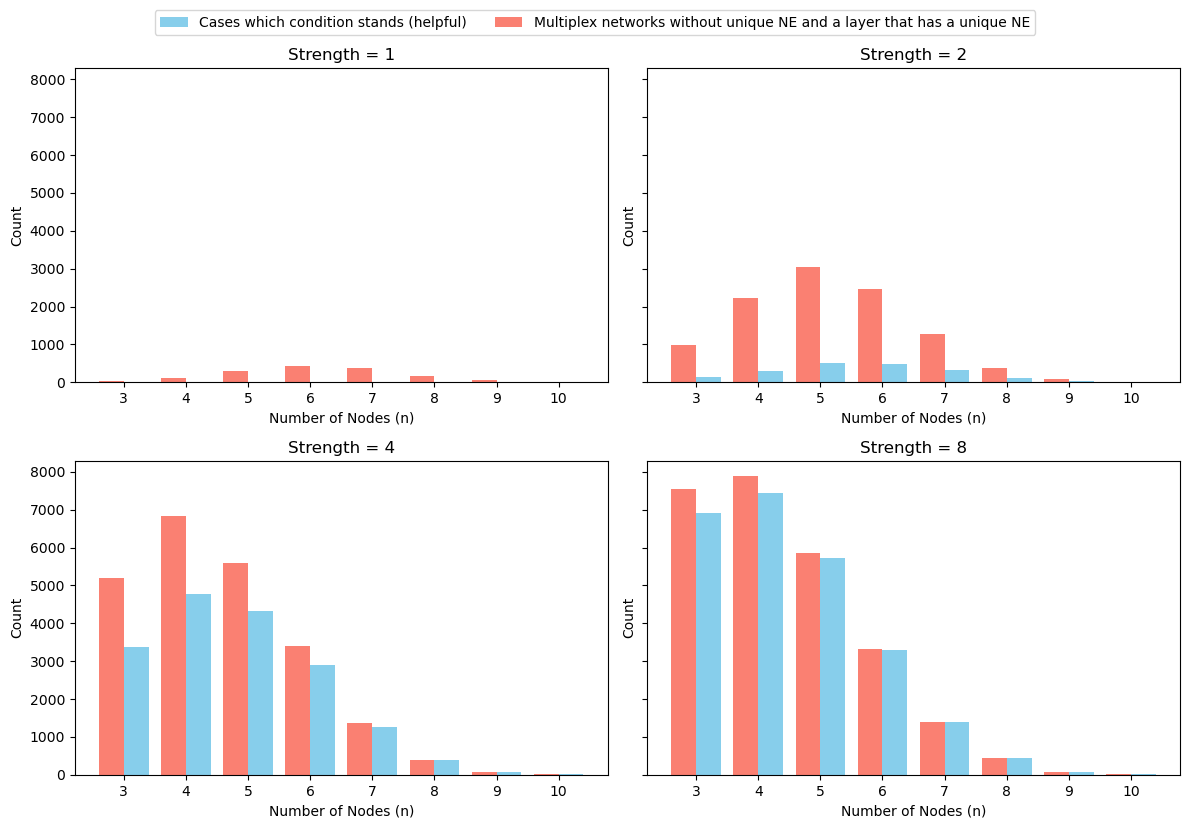

In [25]:
import numpy as np
import matplotlib.pyplot as plt
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5
iterations = 10000
strength_list = [1, 2, 4, 8]

# Prepare the figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()  # Flatten the axs array for easy indexing

# Bar colors
bar_color1 = 'skyblue'
bar_color2 = 'salmon'

# Loop through each strength value
for idx, strength in enumerate(strength_list):
    condition_true_counts = []
    total_counts = []

    for n in n_list:
        condition_true_count = 0
        total_count = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n)*strength
            np.fill_diagonal(G2, 1)
            
            G = kappa * G1 + (1 - kappa) * G2
            result1 = check_p(G1)
            result2 = check_p(G2)
            result = check_p(G)

            lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
            lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
            condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * lambda_max_G1))
                    
            # Check the conditions for unique NEs
            if (result1 & (not result2)) or ((not result1) & result2):
                if not result:
                    total_count += 1
                    # Check condition for the matrices here
                    if condition:
                        condition_true_count += 1

        condition_true_counts.append(condition_true_count)
        total_counts.append(total_count)
    
    # Calculate percentages
    percentages = [ctc / tc * 100 if tc > 0 else 0 for ctc, tc in zip(condition_true_counts, total_counts)]

    # Plotting for this strength value
    ax = axs[idx]
    width = 0.4
    x = np.arange(len(n_list))

    ax.bar(x + width/2, condition_true_counts, width, color=bar_color1, label='Cases which condition stands (helpful)')
    ax.bar(x - width/2, total_counts, width, color=bar_color2, label='Multiplex networks without unique NE and a layer that has a unique NE')

    ax.set_xlabel('Number of Nodes (n)')
    ax.set_ylabel('Count')
    ax.set_title(f'Strength = {strength}')
    ax.set_xticks(x)
    ax.set_xticklabels(n_list)
    # ax.legend()

    # for i, v in enumerate(percentages):
    #     ax.text(i, 8, f'{v:.1f}%')

labels = ['Cases which condition stands (helpful)', 'Multiplex networks without unique NE and a layer that has a unique NE']
fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=2)
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# plt.savefig('multiplex_subplot_2x2.png', dpi=600)
plt.show()


In [7]:
def generate_negative_matrix(n):
    # Generate a random matrix with values between -1 and 0
    matrix = np.random.uniform(-1, 0, (n, n))
    
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

def is_m_matrix(matrix):
    B = matrix - np.eye(n)
    rho = np.max(np.abs(np.linalg.eigvals(-B)))
    return rho < 1

iterations = 5000
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5

for n in n_list:
    for i in range(iterations):
        G1 = generate_negative_matrix(n)
        G2 = generate_matrix(n)
        G = kappa * G1 + (1 - kappa) * G2
        result1 = check_p(G1)
        result2 = check_p(G2)
        result = check_p(G)
        # max eigvals list for G1
        lambda_max_G1 = np.max(np.linalg.eigvals(G1))
        lambda_max_G2 = np.max(np.linalg.eigvals(G2))
        if result1:
            if is_m_matrix(G1):
                condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + ((kappa / (1 - kappa)) * lambda_max_G1)
                if condition & (not result):
                    print("\nwelp!")
                    print(G1)
                    print(G2)
        # lambda_max_G1_list.append(lambda_max_G1)


welp!
[[ 1.         -0.10790176 -0.79167247]
 [-0.93982736  1.         -0.5578    ]
 [-0.84137117 -0.12625075  1.        ]]
[[ 1.         -0.63560808 -0.5013305 ]
 [-0.6928344   1.         -0.02096314]
 [-0.88013294 -0.76860696  1.        ]]

welp!
[[ 1.         -0.13958435 -0.27962616 -0.39822299]
 [-0.07061943  1.         -0.18504065 -0.33499672]
 [-0.38359348 -0.02559313  1.         -0.32314772]
 [-0.67584433 -0.84943105 -0.20535523  1.        ]]
[[ 1.         -0.74190122  0.15947061 -0.61465526]
 [-0.27665098  1.         -0.40713603 -0.45398874]
 [-0.94416812  0.33835949  1.         -0.18682278]
 [-0.66251966 -0.40591943  0.37705704  1.        ]]


In [2]:
# iterations = 1000
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5
# condition_help_list = []
# p_matrix_total_list = []
# strength_list = [0.01, 0.1, 0.5, 1]

# # Prepare the figure for 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# axs = axs.flatten()  # Flatten the axs array for easy indexing

# # Bar colors
# bar_color1 = 'skyblue'
# bar_color2 = 'salmon'

# for idx, strength in enumerate(strength_list):
#     condition_help_list = []
#     p_matrix_total_list = []

#     for n in n_list:
#         condition_help_count = 0
#         p_matrix_total_count = 0

#         for i in range(iterations):
#             G1 = generate_matrix(n)
#             G2 = generate_matrix(n) * strength
#             G = kappa * G1 + (1 - kappa) * G2
#             result = check_p(G)
#             lambda_max_G1 = np.max(np.linalg.eigvals(G1))
#             lambda_max_G2 = np.max(np.linalg.eigvals(G2))
#             condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) - ((kappa / (1 - kappa)) * lambda_max_G1)
#             if condition & result:
#                 condition_help_count += 1
#             if result:
#                 p_matrix_total_count += 1
        
#         condition_help_list.append(condition_help_count)
#         p_matrix_total_list.append(p_matrix_total_count)

#     percentages = [ctc / tc * 100 if tc > 0 else 0 for ctc, tc in zip(condition_help_list, p_matrix_total_list)]

#     # Plotting for this strength value
#     ax = axs[idx]
#     width = 0.4
#     x = np.arange(len(n_list))

#     ax.bar(x + width/2, condition_help_list, width, color=bar_color1)
#     ax.bar(x - width/2, p_matrix_total_list, width, color=bar_color2)

#     ax.set_xlabel('Number of Nodes (n)')
#     ax.set_ylabel('Count')
#     ax.set_title(f'Strength {strength}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(n_list)

#     for i, v in enumerate(percentages):
#         ax.text(i, v + 5, f'{v:.1f}%', ha='center')

# # Adding a single legend at the upper center
# labels = ['Condition Help Count', 'P-Matrix Total Count']
# fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)

# plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# # Uncomment to save the figure
# # plt.savefig('multiplex_subplot_2x2.png', dpi=600)
# plt.show()

# Max eigval experiments


In [11]:
#  define a function to compute the maximum eigenvalue of a matrix
def max_eigenvalue(matrix):
    return np.max(np.linalg.eigvals(matrix))

# define a function to generate sparse matrices of size n
def generate_sparse_matrix(n, lower, upper, threshold):
    # generate a random matrix with values between lower and upper
    matrix = np.random.uniform(lower, upper, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)
    # set all elements below threshold to 0
    matrix[abs(matrix) < threshold] = 0

    return matrix

# define a function to generate random matrices of size n
def generate_random_matrix(n):
    # generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)

    return matrix

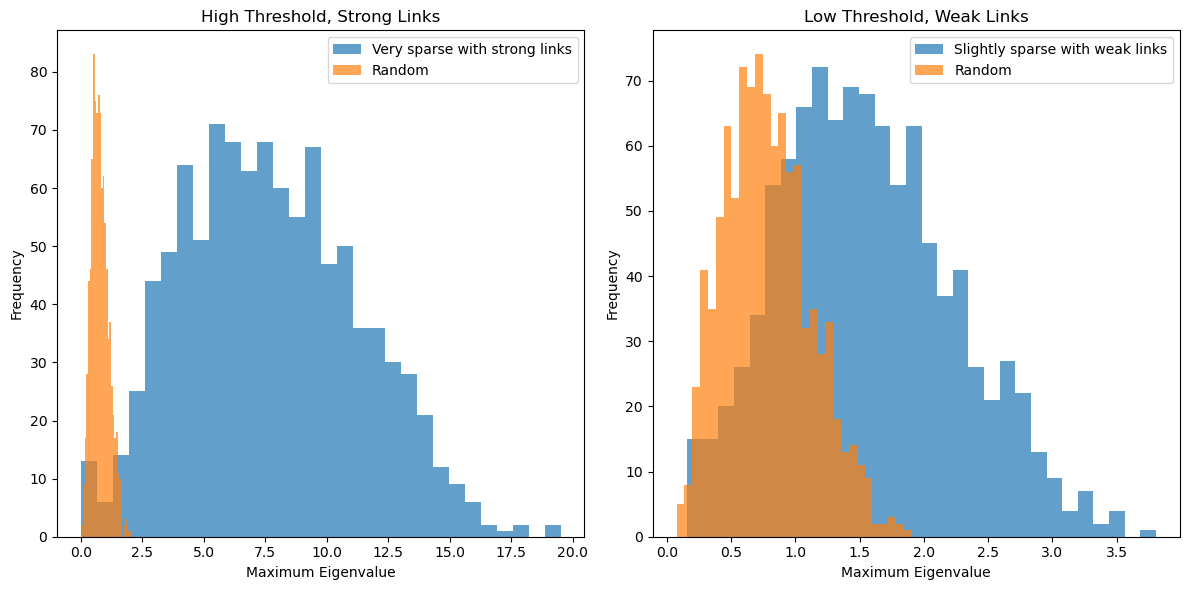

In [15]:
# Define matrix size
n = 5
num_instances = 1000

# Initialize lists to store maximum eigenvalues
max_eigenvalues_sparse_strong = []
max_eigenvalues_random_strong = []
max_eigenvalues_sparse_weak = []
max_eigenvalues_random_weak = []

for _ in range(num_instances):
    # High threshold (very sparse matrix) and strong links (high values of lower and upper)
    sparse_matrix_strong = generate_sparse_matrix(n, -10, 10, 4)
    random_matrix_strong = generate_random_matrix(n)

    # Low threshold (not very sparse) and not very strong links
    sparse_matrix_weak = generate_sparse_matrix(n, -2, 2, 0.1)
    random_matrix_weak = generate_random_matrix(n)

    # Computing max eigenvalues
    max_eigenvalues_sparse_strong.append(max_eigenvalue(sparse_matrix_strong).real)
    max_eigenvalues_random_strong.append(max_eigenvalue(random_matrix_strong).real)
    max_eigenvalues_sparse_weak.append(max_eigenvalue(sparse_matrix_weak).real)
    max_eigenvalues_random_weak.append(max_eigenvalue(random_matrix_weak).real)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(max_eigenvalues_sparse_strong, bins=30, alpha=0.7, label='Very sparse with strong links')
plt.hist(max_eigenvalues_random_strong, bins=30, alpha=0.7, label='Random')
plt.title('High Threshold, Strong Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(max_eigenvalues_sparse_weak, bins=30, alpha=0.7, label='Slightly sparse with weak links')
plt.hist(max_eigenvalues_random_weak, bins=30, alpha=0.7, label='Random')
plt.title('Low Threshold, Weak Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()